In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### **Задание:**
Построить модель градиентного бустинга для многоклассовой классификации для показателя RiskVar на 1 и 2 частях набора данных freMPL. Необходимо предобработать исходные данные (данные содержат ряд других категориальных признаков, не рассматривавшихся на занятиях). Оценить результаты построенного классификатора, выявить возможные проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем. Можно использовать различные методы для подбора гиперпараметров

##### Библиотеки

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

##### Загрузка данных

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False, parse_dates=[2,3])

In [0]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaT,2,Female,Other,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaT,0,Male,Alone,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaT,1,Female,Other,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 22 columns):
Exposure       40732 non-null float64
LicAge         40732 non-null int64
RecordBeg      40732 non-null datetime64[ns]
RecordEnd      21616 non-null datetime64[ns]
VehAge         40732 non-null object
Gender         40732 non-null object
MariStat       40732 non-null object
SocioCateg     40732 non-null object
VehUsage       40732 non-null object
DrivAge        40732 non-null int64
HasKmLimit     40732 non-null int64
BonusMalus     40732 non-null int64
VehBody        40732 non-null object
VehPrice       40732 non-null object
VehEngine      40732 non-null object
VehEnergy      40732 non-null object
VehMaxSpeed    40732 non-null object
VehClass       40732 non-null object
ClaimAmount    40732 non-null float64
RiskVar        40732 non-null float64
Garage         40732 non-null object
ClaimInd       40732 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(5), object(12)
mem

In [7]:
df.nunique().sort_values()

HasKmLimit        2
MariStat          2
Gender            2
ClaimInd          2
Garage            3
VehEnergy         4
VehUsage          4
VehClass          6
VehEngine         6
VehAge            9
VehBody           9
VehMaxSpeed      10
RiskVar          20
VehPrice         27
SocioCateg       52
DrivAge          83
BonusMalus      108
RecordEnd       365
RecordBeg       366
Exposure        757
LicAge          810
ClaimAmount    3193
dtype: int64

##### Подоготовка данных

In [0]:
CAT_FEATURES = ['HasKmLimit',  'MariStat', 'Gender', 'ClaimInd', 'Garage', 'VehEnergy', 'VehUsage', 'VehClass', 'VehEngine', 'VehAge', 'VehBody', 'VehMaxSpeed',
                'VehPrice', 'SocioCateg']
NUM_FEATURES = ['DrivAge', 'BonusMalus', 'Exposure', 'LicAge', 'ClaimAmount']
FEATS = CAT_FEATURES + NUM_FEATURES + ['RecordBeg','RecordEnd']
TARGET = 'RiskVar'
DELETE_FEATURES = []

In [9]:
df.describe()

,Exposure,LicAge,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd
count,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000
mean,0.445484,272.088039,44.323358,0.132500,69.325592,201.735874,13.470588,0.096165
std,0.284627,162.796180,14.732524,0.339038,20.715860,2027.344788,4.722731,0.294821
min,0.001000,0.000000,18.000000,0.000000,50.000000,-3407.700000,1.000000,0.000000
25%,0.195000,139.000000,32.000000,0.000000,50.000000,0.000000,11.000000,0.000000
50%,0.416000,244.000000,42.000000,0.000000,63.000000,0.000000,15.000000,0.000000
75%,0.666000,394.000000,55.000000,0.000000,85.000000,0.000000,17.000000,0.000000
max,1.000000,940.000000,103.000000,1.000000,272.000000,163427.013897,20.000000,1.000000


In [0]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
df = df.drop(columns=DELETE_FEATURES, axis=1)
for column_name in CAT_FEATURES:
    df[column_name ] = labelEncoder.fit_transform(df[column_name]) 
#df = pd.get_dummies(df, columns=['SocioCateg'])

In [0]:
from datetime import timedelta
df['RecordEnd'].fillna(df['RecordBeg']+timedelta(365), inplace=True)
df['Diff_days'] = (df['RecordEnd']-df['RecordBeg']).dt.days
df['Diff_days'] = df['Diff_days'].astype('int')
df = df.drop(columns=['RecordBeg','RecordEnd'], axis=1)
NUM_FEATURES = NUM_FEATURES+['Diff_days']

In [0]:
df.loc[df['ClaimAmount']<0, 'ClaimAmount'] = 0

In [13]:
from sklearn.preprocessing import StandardScaler
scl_x =StandardScaler()
df[NUM_FEATURES] = scl_x.fit_transform(df[NUM_FEATURES].astype('float64'))
df.describe()

,Exposure,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd,Diff_days
count,4.073200e+04,4.073200e+04,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,4.073200e+04,40732.000000,4.073200e+04,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,40732.000000,4.073200e+04,40732.000000,40732.000000,40732.000000,4.073200e+04
mean,-4.680295e-16,4.598218e-16,3.592360,0.648286,0.713518,30.102573,0.832981,-2.219192e-16,0.132500,-1.398539e-14,4.921585,8.247741,3.384317,2.421143,4.762447,2.937322,6.167246e-15,13.470588,0.930080,0.096165,-4.624161e-15
std,1.000012e+00,1.000012e+00,2.525515,0.477511,0.452123,8.812405,0.743880,1.000012e+00,0.339038,1.000012e+00,1.368059,4.363498,1.220703,0.906951,2.253569,1.382461,1.000012e+00,4.722731,0.515238,0.294821,1.000012e+00
min,-1.561655e+00,-1.671362e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.786773e+00,0.000000,-9.329002e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.026899e-01,1.000000,0.000000,0.000000,-1.899747e+00
25%,-8.800538e-01,-8.175233e-01,2.000000,0.000000,0.000000,32.000000,0.000000,-8.364832e-01,0.000000,-9.329002e-01,5.000000,5.000000,2.000000,1.000000,3.000000,2.000000,-1.026899e-01,11.000000,1.000000,0.000000,-9.815419e-01
50%,-1.035901e-01,-1.725371e-01,3.000000,1.000000,1.000000,32.000000,1.000000,-1.577046e-01,0.000000,-3.053539e-01,5.000000,8.000000,4.000000,3.000000,5.000000,3.000000,-1.026899e-01,15.000000,1.000000,0.000000,5.641042e-01
75%,7.747626e-01,7.488717e-01,6.000000,1.000000,1.000000,32.000000,1.000000,7.247077e-01,0.000000,7.566474e-01,5.000000,11.000000,4.000000,3.000000,6.000000,4.000000,-1.026899e-01,17.000000,1.000000,0.000000,8.854762e-01
max,1.948242e+00,4.102800e+00,8.000000,1.000000,1.000000,51.000000,3.000000,3.982845e+00,1.000000,9.783658e+00,8.000000,26.000000,5.000000,3.000000,9.000000,5.000000,8.058053e+01,20.000000,2.000000,1.000000,8.854762e-01


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 21 columns):
Exposure       40732 non-null float64
LicAge         40732 non-null float64
VehAge         40732 non-null int64
Gender         40732 non-null int64
MariStat       40732 non-null int64
SocioCateg     40732 non-null int64
VehUsage       40732 non-null int64
DrivAge        40732 non-null float64
HasKmLimit     40732 non-null int64
BonusMalus     40732 non-null float64
VehBody        40732 non-null int64
VehPrice       40732 non-null int64
VehEngine      40732 non-null int64
VehEnergy      40732 non-null int64
VehMaxSpeed    40732 non-null int64
VehClass       40732 non-null int64
ClaimAmount    40732 non-null float64
RiskVar        40732 non-null float64
Garage         40732 non-null int64
ClaimInd       40732 non-null int64
Diff_days      40732 non-null float64
dtypes: float64(7), int64(14)
memory usage: 6.5 MB


##### Построение модели

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [0]:
df[TARGET] = df[TARGET] -1

In [16]:
df.head()

,Exposure,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd,Diff_days
0,0.483149,0.576875,3,0,1,0,2,0.724708,0,0.129101,5,3,4,3,4,2,-0.102690,14.0,1,0,0.885476
1,-0.862487,-0.522672,0,1,0,34,1,-0.700727,0,0.515283,3,10,2,1,5,4,-0.102690,19.0,1,0,0.885476
2,-1.273556,-0.633242,1,0,1,0,2,-0.768605,0,-0.305354,4,11,2,1,5,4,-0.102690,16.0,1,0,-1.670196
3,-0.247640,-0.627099,1,0,1,0,2,-0.700727,0,-0.305354,4,11,2,1,5,4,-0.102690,16.0,2,0,0.885476
4,0.191536,-0.295392,4,1,1,28,2,0.588952,0,0.129101,8,11,2,1,2,0,0.597672,18.0,1,1,-0.514787


Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [17]:
FreqCount = pd.DataFrame(data=df[TARGET].value_counts())
FreqCount.index.name = TARGET
FreqCount.columns = ['Count']
FreqCount['Freq'] = FreqCount['Count']/df.shape[0]
FreqCount 

,Count,Freq
RiskVar,,
15.0,4906,0.120446
14.0,4625,0.113547
16.0,3444,0.084553
19.0,2894,0.071050
18.0,2773,0.068079
12.0,2719,0.066753
17.0,2614,0.064176
10.0,2533,0.062187
11.0,2445,0.060027


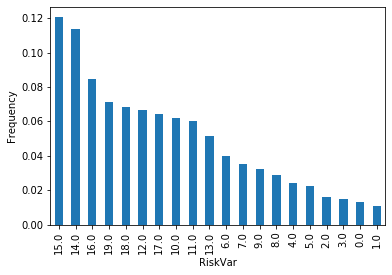

In [18]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [0]:
df['weight'] = 0.75
df.loc[df[TARGET].isin([14,15]) , 'weight'] = 0.5
df.loc[df[TARGET].isin([16]) , 'weight'] = 0.6
df.loc[df[TARGET].isin([1,0, 3, 2, 5, 4, 8, 9 ,7, 6]) , 'weight'] = 1

In [20]:
df['weight'].value_counts()

0.75    18074
1.00     9683
0.50     9531
0.60     3444
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
# Разбиение датасета на train/val/test

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=TARGET, axis=1), df[TARGET], stratify= df[TARGET], test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, stratify= y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [22]:
xgb_train = xgb.DMatrix(data=x_train.drop('weight', axis=1),label= (y_train), weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop('weight', axis=1),label= (y_valid), weight=x_train['weight'])
xgb_test =  xgb.DMatrix(data=x_test.drop('weight', axis=1), label= (y_test), weight=x_train['weight'])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:

params = {'alpha': 0.8188267506985407,
          'colsample_bytree': 0.730304738424674,
          'eta': 0.10162516795034682,
          'eval_metric': 'mlogloss',
          'lambda': 0.48066389042451657,
          'max_depth': 12,
          'min_child_weight': 0.10803644133630286,
          'num_boost_round': 429.0,
          'num_class': 20,
          'objective': 'multi:softprob',
          'seed': 10,
          'subsample': 0.5017331721376306,
          'tree_method': 'gpu_hist'
         }

model = xgb.train(params,  xgb_train)


In [0]:
def prepare_result(predictions):
    df_class_preds = pd.DataFrame(predictions)
    return df_class_preds.idxmax(axis=1)

In [25]:
from sklearn.metrics import log_loss

def print_score(model, x_valid, label_valid):
  pred_valid = model.predict(x_valid)
  score = log_loss(label_valid, pred_valid, labels=range(20))
  print(f'Logloss:{score}')
  score = f1_score(label_valid, prepare_result(pred_valid)  , average='micro')
  print(f'f1_score:{score}')

print_score(model, xgb_train, y_train)
print_score(model, xgb_valid, y_valid)


Logloss:2.4212918750644903
f1_score:0.5839646464646465
Logloss:2.785812324841557
f1_score:0.20409165302782323


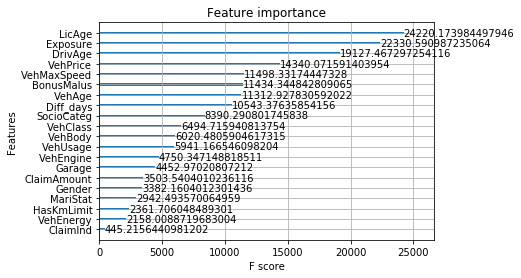

In [26]:
importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(model, importance_type=importance_type[0]); plt.show()

In [27]:
ALL_FEATS=sorted(model.get_fscore().items(), key=lambda x:x[1], reverse=True)
ALL_FEATS

[('Exposure', 9656),
 ('LicAge', 9184),
 ('DrivAge', 7395),
 ('VehPrice', 5344),
 ('Diff_days', 4518),
 ('VehAge', 4397),
 ('BonusMalus', 4358),
 ('VehMaxSpeed', 4206),
 ('SocioCateg', 3032),
 ('VehClass', 2536),
 ('VehBody', 2357),
 ('VehUsage', 2201),
 ('VehEngine', 1812),
 ('Garage', 1745),
 ('ClaimAmount', 1372),
 ('Gender', 1265),
 ('MariStat', 1088),
 ('HasKmLimit', 952),
 ('VehEnergy', 782),
 ('ClaimInd', 174)]

##### Подбор гиперпараметров 

In [0]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    df_class_preds = pd.DataFrame(y_pred)
    y_pred_max =  df_class_preds.idxmax(axis=1)
    err = 1-f1_score( y_true, y_pred_max, average='micro')    
    return 'f1_err', err

In [0]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    global xgb_train
    parameters = {
        'objective': params[ 'objective'],
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': params[ 'num_class'],
        'tree_method': params['tree_method'],
        'eval_metric':params['eval_metric'],
        'seed':params['seed']
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']), nfold=5, seed=10, maximize=False, early_stopping_rounds=10, feval=f1_eval)
    score = cv_result['test-f1_err-mean'][-1:].values[0]
    return score

In [0]:
# Определим границы, в которых будем искать гиперпараметры 

space = {
         'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
         'num_class': 20,
         'objective': 'multi:softprob',
         'tree_method': 'gpu_hist',
          'eval_metric':'mlogloss',
          'seed':10
        }

In [31]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

100%|██████████| 20/20 [13:26<00:00, 28.10s/it, best loss: 0.7611888]


In [32]:
best_params = space_eval(space, best)
best_params

{'alpha': 0.9604300297355819,
 'colsample_bytree': 0.6460360678232007,
 'eta': 0.3200457720356095,
 'eval_metric': 'mlogloss',
 'lambda': 0.16474584783745205,
 'max_depth': 12,
 'min_child_weight': 0.8719037947725938,
 'num_boost_round': 162.0,
 'num_class': 20,
 'objective': 'multi:softprob',
 'seed': 10,
 'subsample': 0.7410991209616851,
 'tree_method': 'gpu_hist'}

In [0]:
progress = dict()
xgb_multiclass = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params,  dtrain=xgb_train, feval=f1_eval, maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")], 
                           early_stopping_rounds=15, evals_result=progress, verbose_eval=False)

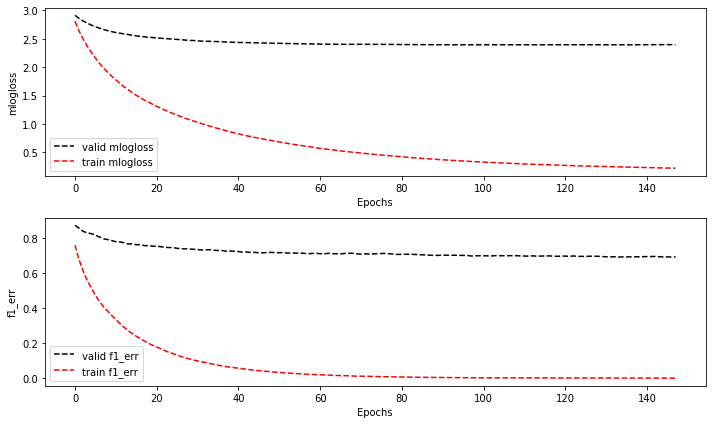

In [34]:
plt.subplots(2,1, figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(progress['valid']['mlogloss'], label='valid mlogloss', linestyle='dashed', color='black')
plt.plot(progress['train']['mlogloss'], label='train mlogloss', linestyle='dashed', color='red')
plt.xlabel('Epochs'); plt.ylabel('mlogloss'); plt.legend(); plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(progress['valid']['f1_err'], label='valid f1_err', linestyle='dashed', color='black')
plt.plot(progress['train']['f1_err'], label='train f1_err', linestyle='dashed', color='red')
plt.xlabel('Epochs'); plt.ylabel('f1_err'); plt.legend(); plt.tight_layout()

In [35]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds =  prepare_result(xgb_multiclass.predict(dfset['dmat']))
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds , average='micro')) 

F1 Score on train: 0.9997895622895623
F1 Score on valid: 0.3057283142389525
F1 Score on test: 0.3111292962356792


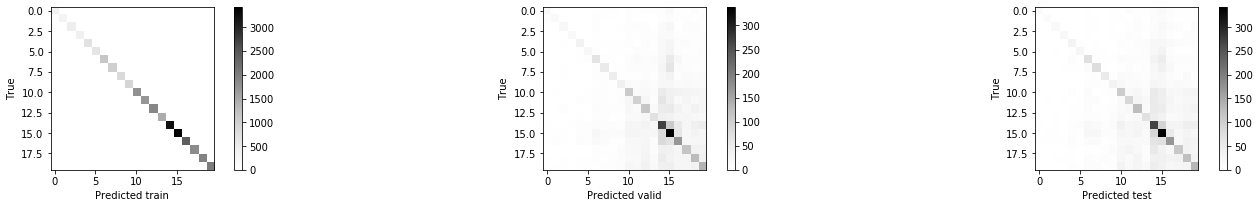

In [36]:
plt.subplots(1,3, figsize=(25,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], prepare_result(xgb_multiclass.predict(dfsets[i]['dmat'])))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted '+ str(dfsets[i]['set']))
plt.show()

##### Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

О модели:

1. Модель переобучена - оценка метрики на train сильно отличается от valid и test. При этом графике хорошо видно, как быстро модель на train переобучается. Регулиризация L1 и L2 помогает слабо по найденным параметрам alpha и lambda.
2. Из-за преобладания классов 14 и 15 (дисбаланс классов), то к ним ошибочно модель относит другие метки, что хорошо видно на матрице. Добавление весовых коэффициентов улучшает метрику, но решает проблему дисбаланса классов не полностью.
3. Типовые синтетические фичи (умножение, деление, возведение в степень) не улучшали метрику. 

Для улучшения модели можно попробовать:
1. Oversampling вместо весов
2. Увеличить max_evals для подбора гиперпараметров.
3. Для категориальных признаков использовать label-кодирование, а не one-hot. 
